In [119]:
import pandas as pd
import time
from datetime import date, timedelta
import numpy as np
import re
import json
import matplotlib.pyplot as plt
import csv 
from helper import * # File containig some helper functions
import os
import folium
import branca.colormap as cm
from folium.plugins import MarkerCluster
from folium import plugins
import ast
import math

# [Link to interactive visualisation](https://nbviewer.jupyter.org/github/brunowicht/ada_project/blob/master/project/project.ipynb)

# 0. Understanding the dataset

Before starting any kind of data analysis, we first have to review the content of our dataset and understand its meaning better. To do this, we use the data sample and the schema provided with the dataset.

## 0.1. Dataset structure
Let us first read the `schema.txt` file to understand what fields our dataset contains.

In [ ]:
schema = pd.read_table('twitter-swisscom/schema.txt', delimiter='    ', engine='python',
                       names=['Field name', 'Type', 'Specification', 'Unsigned', 'Optional field', 'Format'] )
schema

The `schema.txt` contains information about each field in our dataset. We see that there are 20 possible fields for a tweet, but many of them are optional, so most tweets probably haver fewer specified field than that.

Here are the fields that will be the most useful:
- userId: to know who posted the tweet
- createdAt: to know when the tweet was posted
- text: content of the tweet
- longitude and latitude: to know from where the tweet was posted


## 0.2. Dataset contents
Now, let us have a look at the actual content of our dataset using the provided sample.

In [ ]:
sample_df = pd.read_csv('twitter-swisscom/sample.tsv', encoding='utf-8', sep='\t', escapechar='\\', 
                        index_col='id', names=schema['Field name'], quoting=csv.QUOTE_NONE, na_values='N')
sample_df.head()

Let us check the percentage of `NaN` values for each field.

In [ ]:
sample_df.isnull().sum().apply(lambda s: '{0:.2f} %'.format(100*s/sample_df.shape[0]))

We can observe that the `latitude` and `longitude` are quite often `NaN`, whereas the `placeLatitude`and `placeLongitude` fields are always specified. Therefore, we will use the latter fields.

Let us visualize the geographical distribution of the tweets in the sample dataset.

In [ ]:
swiss_coord = [46.8, 8.2]
swiss_map = folium.Map(swiss_coord, zoom_start=8)
add_markers_to_map_(sample_df.rename(columns={"placeLongitude": "Latitude", "placeLatitude": "Longitude"}), swiss_map, False)

In [ ]:
swiss_map

# 1. Data cleaning and pre-processing

In [ ]:
#All the columns in the original dataset
col = ['id', 'userId', 'createdAt', 'text', 'long', 'lat', 'placeId', 'inReplyTo', 'source', 'truncated', 'Longitude',\
       'Latitude', 'sourceName', 'sourceUrl', 'username', 'screenName', 'followerscount', 'friendscount', 'statusescount',\
       'userLocation']

#Columns we keep before any computation
keep_col = ['id', 'userId', 'createdAt', 'text', 'Longitude', 'Latitude', 'username']

#Columns we have after tag and identification filtering
keep_final = ['id', 'userId', 'createdAt', 'Longitude', 'Latitude', 'username', 'tag', 'at']


Here we have the script for reading the whole dataset, filter the tags and identification in the text and store everything in a dataframe.  
The function `add_lines_in_df(lines, dataframe)` takes a list of tweets, compute the hashtags (all the hashtags have been lowercased because uppercase does not add any information) and indentifications, filter the columns and add it to a building dataframe. We are doing the dataframe construction part by part because it was too heavy to do it all at once.  
The tricky part of this method with `readline()` is that if a tweet contains a \n character, this means that this is the end of the tweet tuple and the next part of the true tweet tuple will be seen as a new tweet tuple. So we need to check that every tweet tuple contains 20 element, and if not we concatenate the next line read to it until there is at least 20 element in the tuple.

In [ ]:
file = open("../../twitter_dataset/twitter_full.tsv", encoding="utf8")
data = file.readline()
#j is just to keep track where we stand in the reading of the file
j = 0
data_list = list()
df = None
while not data == "":
    j+=1
    l = len(data.split('\t'))
    #check that a tweet tuple is at least 20 element, if not concatenate next line read.
    while l < 20:
        data += file.readline()
        l = len(data.split('\t'))
    #only tuples of 20 element are valid
    if l == 20:
        data_list.append(data.split('\t'))
    #every 50000 tuples, add them to the building dataframe and empty the list to not cause memory overflow
    if j%50000 == 0:
        #print is just to inform where we are in the file
        print(str(j/20212854.0), end='\r')
        df = add_lines_in_df(data_list, df)
        data_list = list()
    
    data = file.readline()
    #if no more data, add the list to the dataframe and go out of the loop
    if data == "":
        print(str(j/20212854.0))
        df = add_lines_in_df(data_list, df)
        data_list = list()
    

file.close()

To be able to easily group by day, month or year, we decided to add those three columns to our dataframe, so we can drop the createdAt column which contains also the time (with second precision) of the tweet post, but we will not need it. We still need to set the tweet id as the unique index of tweets to be able to retreive some information in the original dataset if needed.

In [ ]:
df['day'] = df.createdAt.apply(lambda x : x[:10])
df['month'] = df.createdAt.apply(lambda x : x[:7])
df['year'] = df.createdAt.apply(lambda x : x[:4])
df = df.drop(['createdAt'],axis=1)
df = df.set_index('id')

We can then store the resulting dataframe in a new csv file which is around 3 times smaller than the original one. We can then filter tweet that contains at least one hashtag and thos which contains at least one identification to create subdataset as we want to work with hashtags and identifications.

In [ ]:
df.to_csv('../../twitter_dataset/cleaned.csv', sep=';', encoding='utf-8')

In [ ]:
df_tag = df[(df["tag"].astype(str) != '[]')]
df_tag.to_csv('../../twitter_dataset/cleaned_hashtag.csv', sep=';', encoding='utf-8')

In [ ]:
df_at = df[(df["at"].astype(str) != '[]')]
df_at.to_csv('../../twitter_dataset/cleaned_identification.csv', sep=';',encoding='utf-8')

# 2. Data Manipulation
## 2.1. Grouping by hashtag

The first step of our descriptive data analysis is to group all tweets by hashtags. In other words, we want to have a dataframe containing for each hashtag the indices of the tweets in which it appears. This will allow us to count find the most popular hashtags, and later agregate them by time.

First, we retrieve our cleaned dataset containing tweets with hashtags by loading it from the file we save in the previous step. This allows us to avoid unnecessary computations.

In [121]:
df_tag = pd.read_csv("../../twitter_dataset/cleaned_hashtag.csv", sep=';', encoding="utf-8")

//anaconda/envs/ada/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Then we can implement the main function that will group our data by hashtag as described above.

For the sake of clarity, the following functions were moved in the `helper.py` file:
- `get_hashtags(text, lowercase=True)` : Returns the list of all hashtags present in the given text.
- `get_index_with_hashtag(df, hashtag)` : Returns the indices of the tweets in which the given hashtag appears.

In [ ]:
def group_by_hashtag(df):
    """For each hashtag, give the indices of the tweets in which it appears.
    
    df: dataframe to use for the grouping
    load_hashtags_list: if True, loads the list of different hashtags from a file saved previously.
                        if False, computes the hashtag list again.
    """
    
    # Get the indices of the tweets in which each hashtag appears
    output = {}
    for index, item in df.iterrows():
        tags = get_hashtags(item.tag, lowercase=False)
        for tag in tags:
            if(tag in output):
                output_tag = output[tag]
                output_tag[0].append(index)
                output_tag[1].append(item.userId)
            else:
                output[tag] = [[index], [item.userId]]
    
    for tag, lists in output.items():
        output_tag = output[tag]
        output_tag[0] = list(np.unique(np.array(lists[0])))
        output_tag[1] = len(np.unique(np.array(lists[1])))
    
    
    
    # Convert to dataframe
    output_df = pd.DataFrame.from_dict(output, orient='index')
    output_df.reset_index(inplace=True)
    output_df.columns = ['hashtag', 'tweets_idx', 'nb_unique_authors']
    return output_df

Then we can actually call this function on our dataset. We store the result in a csv file so that we won't have to compute it again.

In [ ]:
# Compute the groups by hashtag
group_hashtags = group_by_hashtag(df_tag)
group_hashtags = group_hashtags.set_index("hashtag")

# Save result to csv file
group_hashtags.to_csv("../../twitter_dataset/hashtag_grouped.csv", sep=";", encoding="utf-8", columns=["tweets_idx", "nb_unique_authors"])

In [120]:
# Read hashtag groups from file
group_hashtags = pd.read_csv("../../twitter_dataset/hashtag_grouped.csv", sep=";", index_col=[0], usecols=[0, 1, 2])
group_hashtags.tweets_idx = group_hashtags.tweets_idx.apply(lambda s: ast.literal_eval(s))
group_hashtags.head()

,tweets_idx,nb_unique_authors
hashtag,,
#instabeautiful,"[359953, 961976, 2067053, 2250249, 2250301]",4
#varrialemaiale,"[1003936, 1753632]",2
#bainschauds,[2273733],1
#minho,"[2473162, 2524797, 2743672]",2
#tescheloucommekanyewest,[1145882],1


We now have for each hashtag of our dataset the indices of the tweets in which it appears. With that data, we can for example see what hashtags were tweeted the most.

In [4]:
group_hashtags_nb = group_hashtags.copy()

# Get the occurence of each hashtag
group_hashtags_nb['tweets_nb'] = group_hashtags_nb['tweets_idx'].apply(lambda ls: len(ls))

# Get the 1510most popular hashtags
group_hashtags_nb.sort_values('tweets_nb', ascending=False).drop(['tweets_idx'], axis=1).head(10)

,nb_unique_authors,tweets_nb
hashtag,,
#switzerland,17347,63364
#lrt,4692,45596
#lt,5306,43009
#newyearrocks,32634,38256
#job,604,33736
#christmasrocks,27426,32530
#zurich,7621,28660
#np,3244,28003
#geneva,5783,26907


# 3. Data Analysis and Visualization

## 3.1. Visualizing hashtag frequency
We want to be able to determine if a certain hashtag has a spike of popularity at a certain time. To do that, we visualize the number of tweets containing a given hashtag per unit of time (day, month, or year)

For the sake of clarity, the following functions were moved in the `helper.py` file:
- `search_hashtag(hashtag, df)` : Filter the given dataset to keep only elements that contain the given hashtag.
- `plot_frequency_tags(df, col, hashtag, n)` : Display a bar plot of the number of tweets with the given hashtag per unit of time given in 'col' (day, month or year) .

For example, let us take a look at the tweets with the hashtag '#jesuischarlie'.

In [5]:
df_Charlie = search_hashtag("'#jesuischarlie'", df_tag)
df_Charlie.head(10)

,id,userId,Longitude,Latitude,tag,at,day,month,year
2122726,552805185706545153,23783420,47.3774,8.53676,['#jesuischarlie'],[],2015-01-07,2015-01,2015
2122729,552805619062038529,23783420,47.3774,8.53676,"['#journalisten', '#medienfreiheit', '#jesuisc...",[],2015-01-07,2015-01,2015
2122740,552806885053988865,414754156,46.5287,6.65208,"['#charliehebdo', '#jesuischarlie']",[],2015-01-07,2015-01,2015
2122747,552807441407434752,448198451,46.2048,6.14319,"['#cabu', '#charliehebdo', '#jesuischarlie']",[],2015-01-07,2015-01,2015
2122750,552807881012424705,448198451,46.2048,6.14319,"['#jesuischarlie', '#charliehebdo']",[],2015-01-07,2015-01,2015
2122751,552808524020215808,2556353232,47.6206,6.78752,['#jesuischarlie'],[],2015-01-07,2015-01,2015
2122753,552808602835369984,448198451,46.2048,6.14319,"['#charb', '#charliehebdo', '#jesuischarlie']",[],2015-01-07,2015-01,2015
2122763,552809303636475904,129821394,46.8031,7.15962,"['#jesuischarlie', '#charliehebdo']",['@Charlie_Hebdo_'],2015-01-07,2015-01,2015
2122765,552809353657729024,391267192,46.01,7.3331,['#jesuischarlie'],[],2015-01-07,2015-01,2015
2122779,552810466050052096,634553,46.1795,6.14126,"['#charliehebdo', '#jesuischarlie']",[],2015-01-07,2015-01,2015


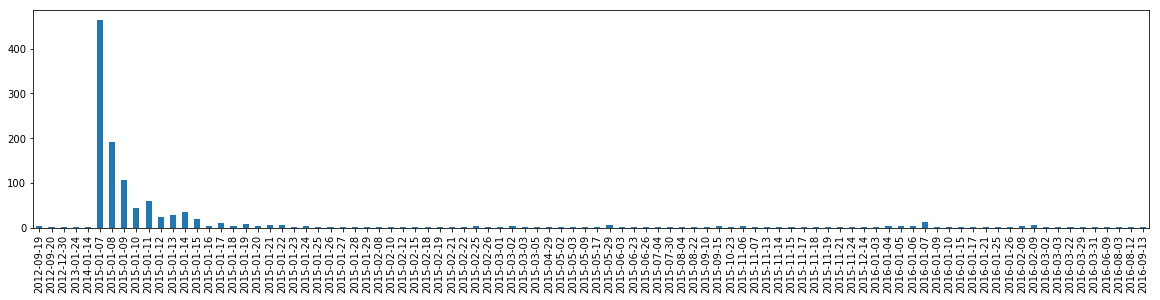

In [6]:
plot_frequency_tags(df_tag, 'day', "#charliehebdo", 100)

Let us now try this for events that take place every year at the same period, for example Eurovision and Paléo Festival.

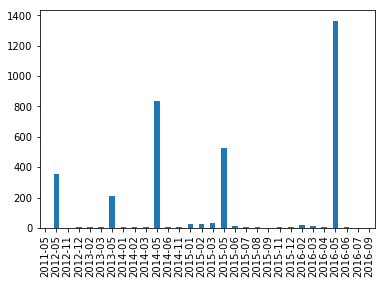

In [7]:
plot_frequency_tags(df_tag, 'month', "#eurovision", 30)

For Eurovision, we can clearly see a spike each year during the month of may, which is indeed when the contest takes place.

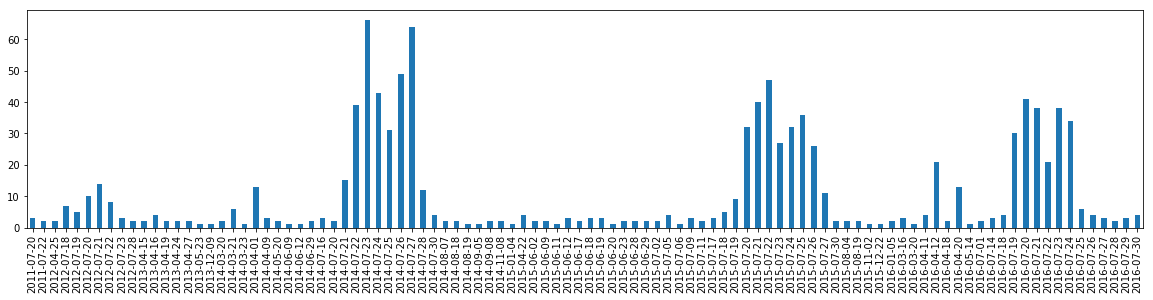

In [8]:
plot_frequency_tags(df_tag, 'day', "#paleo", 100)

For Paléo Festival, we can again see a spike each year during the end of month of July, but this time we can also see that it lasts about a week.

## 3.2 Geographic event localisation

Here we can use the geographic information of the tweets to determine the location of an event. To do so, we display on a map the geolocation of each tweet that mentions a given hashtag. The following function were implemented in order to create this map.

In [9]:
def popup_html(row):
    '''
        Return the html to create a popup for the dataframe row.
    '''
    return """
    <style>
    h3 {
        color: black;
        font-size: 16px;
        text-align: center;
    }
    </style>
    <h3> %s </h3>
    <h3> %s </h3>
    """ %( row.day, str(row.tag.replace("'", "").replace("[", "").replace("]", "")) )

def add_markers_to_map_(dataframe, map_, popup = True, maxClusterRadius = 10):
    '''
        Add the clusters of markers from the dataframe to the given map. 
    '''
    popups = []
    coordinates = []
    for index,row in dataframe.iterrows():
        if row.Latitude != '\\N' and row.Longitude != '\\N':
            coordinates.append([float(row.Longitude), float(row.Latitude)])
            if popup:
                popups.append(folium.Popup(popup_html(row)))
            else:
                popups.append("")
            
    marker_cluster = MarkerCluster(locations=coordinates, 
                                   popups=popups).add_to(map_)
           
def get_map_with_hasthtag(hashtag):
    '''
        Create a map with the markers for the given hashtag.
    '''
    swiss_coord = [46.8, 8.2]
    
    swiss_map = folium.Map(swiss_coord, zoom_start=8)
    
    # Get the dataframe of the tweet containing the hashtag.
    indexes = get_index_with_hashtag(df_tag, hashtag)
    event_df_tag = df_tag.iloc[indexes[0]]
    
    add_markers_to_map_(event_df_tag, swiss_map)
    
    return swiss_map

Now let us try this with Eurovision and Paléo Festival, which were already used as examples previously. As we can see in the maps below, Eurovision is an international event since the geographic repartitions of tweet is quite homogenous over Switzerland. On the other hand, if we look at the hashtag '#paleo', we can quickly see that it takes place in Nyon because there is a very high concentration of tweets about Paléo in that area.

In [ ]:
get_map_with_hasthtag("eurovision")

In [ ]:
get_map_with_hasthtag("paleo")

# 4. Event detection

## 1. Filtering out irrelevant hashtags
<div style="background-color:red;padding:10px;margin:10px;color:white">
**TODO: Keep only unique tweet indices in the group_hashtag df, rewrite it and update the code that generates it. **
</div>

In [11]:
group_df_filtered = group_hashtags.sort_values('nb_unique_authors', ascending=False)
#group_df_filtered = group_df_filtered[group_df_filtered['tweets_nb'] > 100]
group_df_filtered = group_df_filtered[group_df_filtered['nb_unique_authors'] > 50]
group_df_filtered.count()

tweets_idx           6197
nb_unique_authors    6197
dtype: int64

In [12]:
#group_hashtags = group_hashtags.set_index('hashtag')

In [13]:
#group_df_filtered = group_df_filtered.set_index('hashtag')

## 2. Basic algorithm

In [124]:
def get_unique_authors_from_tweet_ids(tweet_ids):
    return len(np.unique(df_tag.iloc[tweet_ids]['userId'].values))

def get_unique_author_per_day(df):
    """Returns a dictionnary containing for each hashtags a dictionnary of dates
       and the corresponding number of user that has tweeted this hashtag that day."""
    
    dic_tag_days = {}
    
    for idx, row in df.iterrows():
        grouped_day = df_tag.iloc[row['tweets_idx']].groupby('day')
        dic_tag_days[idx] = grouped_day.apply(lambda x: get_unique_authors_from_tweet_ids(x.index.values)).to_dict()
    
    return dic_tag_days

In [125]:
dic_tag_days = get_unique_author_per_day(group_df_filtered.head(100))
dic_tag_days.keys()

dict_keys(['#soldout', '#swissalps', '#wcw', '#views', '#closingceremony', '#r8', '#funghi', '#spider', '#astonmartin', '#waterfall', '#sp', '#summeriscoming', '#studio', '#engadina', '#streetphotography', '#f4f', '#leafs', '#curling', '#flag', '#hungergames', '#friday', '#addio', '#collection', '#riprobinwilliams', '#chaos', '#salope', '#reflections', '#picnic', '#karma', '#skiing', '#chicago', '#brothers', '#listen', '#autumn', '#glace', '#srfrundschau', '#missfrance2014', '#cablecom', '#higuain', '#lech', '#piscine', '#top', '#amala', '#feusurtoi', '#fortboyard', '#traveller', '#genial', '#cm2014', '#swe', '#in', '#newpp', '#theater', '#fact', '#nye', '#different', '#ss7', '#lundi', '#lecture', '#france2', '#hartaberfair', '#golf', '#memories', '#ard', '#fiori', '#tweets', '#favorite', '#lp', '#420', '#gutenacht', '#teamitalia', '#lakeconstance', '#presents', '#lifeisbeautiful', '#lamp', '#imieiplayoff', '#market', '#app', '#estate', '#asap', '#i', '#exercise', '#likeforlike', '#are

In [126]:
def plot_hashtag_occurence_for_dates(hashtag, dic_tag_days, start_date, end_date):
    """Display a bar plot of the number of unique users that
       tweeted the given hashtag between the given dates.
    """
    # Get the total number of days to be displayed
    delta = end_date - start_date
    nb_days = delta.days + 1
    
    # Create the array of string containing every day between the given end and start dates
    dates = [str(start_date + timedelta(days=i)) for i in range(nb_days)]
    # Get the corresponding nuber of unique users having tweeted the hashtag
    nb_authors = [dic_tag_days.get(hashtag).get(d, 0) for d in dates]
    
    # Set the label for the xticks
    date_ticks_period = math.ceil(nb_days/50)
    date_ticks = [(dates[i] if i%date_ticks_period==0 else "") for i in range(nb_days)]
    
    # Display the bar plot
    width = 0.5 if (nb_days < 200) else 1.0
    left = [l + (1-width)/2 for l in range(nb_days)]
    plt.figure(figsize=(min(20, nb_days/4),4))
    plt.title(hashtag)
    plt.bar(left, nb_authors, width=width)
    plt.xticks(left, date_ticks, rotation='vertical')
    plt.ylabel("Number of unique users \n that tweeted the hashtag ")
    plt.show()

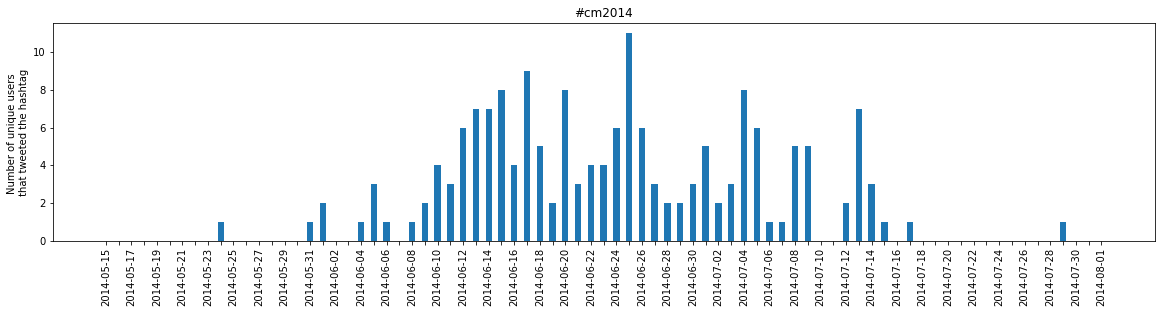

In [127]:
plot_hashtag_occurence_for_dates('#cm2014', dic_tag_days, date(2014, 5, 15), date(2014, 8, 1))

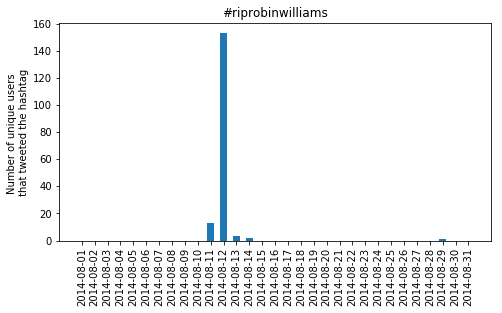

In [136]:
plot_hashtag_occurence_for_dates('#riprobinwilliams', dic_tag_days, date(2014, 8, 1), date(2014, 8, 31))

In [138]:
def get_average_unique_authors(hashtag, dic_tag_days, start_date, end_date):
    # Get the total number of days to be displayed
    delta = end_date - start_date
    nb_days = delta.days + 1
    
    # Create the array of string containing every day between the given end and start dates
    dates = [str(start_date + timedelta(days=i)) for i in range(nb_days)]
    # Get the corresponding nuber of unique users having tweeted the hashtag
    nb_authors = [dic_tag_days.get(hashtag).get(d, 0) for d in dates]
    
    mean = np.mean(nb_authors)
    return mean

In [143]:
get_average_unique_authors('#cm2014', dic_tag_days, date(2010, 1, 1), date(2016, 12, 31))

0.10856807511737089

In [142]:
get_average_unique_authors('#riprobinwilliams', dic_tag_days, date(2010, 1, 1), date(2016, 12, 31))

0.10093896713615023

## 3. Algorithm Optimization

## 4. Event localisation

(Please refer to the README.md file for a more precise description)